# Growth Rate Calculations for the Pathway Library

The following code converts raw sgRNA counts to relative growth rates for the entire 19-gene pathway library. This is performed by normalizing raw counts to relative counts and fitting a line to the log$_2$(Relative Counts) vs. Generations relationship. The code also removes escapers, averages replicates, and rescales growth rates to an intuitive, non-negative scale. Directly adapted from the code used on the initial pairwise CRISPRi library.

6/28/22 - Ryan Otto
2/17/23 - Ryan Otto
8/29/23 - Ryan Otto
10/12/23 - Ryan Otto

### Import packages and libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '231012'  # Date for output files
figure_path = 'Figures'  # Path for figure output
file_path = 'intermediate_files'  # Path for data files
input_path = 'input_files'
counts_path = 'input_files/Pathway_Counts'  # Path for count data
TPs = [0, 2, 4, 6, 8, 10]
BC_list = ['CTTTCA', 'GCATGG', 'ATCATG']

### Import data 

In [3]:
pairwise_dict = {TP:{} for TP in TPs}
for TP in TPs:
    for BC in BC_list:
        pairwise_dict[TP][BC] = \
        pd.read_csv(f'{counts_path}/230821_T{TP}_{BC}_counts.csv').set_index('Unnamed: 0')
sgRNA2seq, seq2sgRNA = {}, {}
with open(f'{input_path}/Pathway_Lib.fasta') as FI:
    full_seq = FI.readlines()
    for i, line in enumerate(full_seq):
        if line[0] == '>':
            seq2sgRNA[full_seq[i+1][35:55]] = line[2:-1]
            sgRNA2seq[line[2:-1]] = full_seq[i+1][35:55]
sgRNA_list = ['negC_rand_42']
gene_names = ['dapA', 'dapB', 'dapD', 'dapF', 'dnaB', 'dnaE', 'dnaX', 'holB', 'ligA', 'parE', 'purD', 'purL', 'purN',
              'eno', 'fbaA', 'gapA', 'pfkA', 'pgi', 'tpiA']
for gene in gene_names:
    # The purF sgRNA was hand-annonated as off-target -- there was no titration of GR with homology, and the most
    # highly mismatched sgRNA had the most severe GR defect, a sign that it targets elsewhere in the genome
    if gene not in ['negC', 'fake', 'purF']:
        temp_sgRNAs = {}
        for sgRNA in sgRNA2seq:
            if sgRNA.startswith(gene):
                if sgRNA.endswith('C'):
                    temp_sgRNAs[sgRNA] = 0
                else:
                    temp_sgRNAs[sgRNA] = int(sgRNA.split('_')[-1][2:])
        sorted_sgRNAs = dict(sorted(temp_sgRNAs.items(), key=lambda item: item[1]))
        for sgRNA in list(sorted_sgRNAs.keys())[::-1]:
            sgRNA_list.append(sgRNA)
sgRNA_list.remove('purN_3_238_B_MM8')  # This sgRNA was not properly synthesized (frequency <<< all other sgRNAs)
with open(f'{file_path}/231012_df_growth_pool_filt.pickle', 'rb') as handle:
    pairwise_gr_all = pickle.load(handle)
with open(f'{file_path}/231012_df_growth_pool_filt_sem.pickle', 'rb') as handle:
    pairwise_sem_all = pickle.load(handle)

### Define analysis functions

In [4]:
def growth_rate(sgRNA1, sgRNA2, freq_dict, count_dict, TPs_hours, BC_ID):
    """Calculates growth rate for a given barcoded sgRNA construct
    Arguments:
    sgRNA1: Name of position 1 sgRNA
    sgRNA2: Name of position 2 sgRNA
    BC_ID: Barcode identity
    freq_dict: Dictionary containing log2-transformed relative frequencies
    count_dict: Dictionary contining CRISPRi construct counts at each timepoint
    TPs_hours: Timepoints (hours)
    Returns:
    m: Growth rate (slope) of CRISPRi construct
    b: Intercept of log2(relative frequency) to generations best fit line
    """
    rel_freq = np.array([freq_dict[TP][BC_ID].loc[sgRNA1, sgRNA2] for TP in TPs_hours])
    counts = np.array([count_dict[TP][BC_ID].loc[sgRNA1, sgRNA2] for TP in TPs_hours])
    for i, count in enumerate(counts):
        if count < 10 or np.isnan(count):  # If counts fall below our minimum threshold, don't count next timepoints
            if ~np.isnan(rel_freq[i]):  # If the construct isn't absent, include this point and no future ones
                rel_freq = rel_freq[:i + 1]
                TPs_hours = TPs_hours[:i + 1]
            else:  # If counts are zero, don't include this point or future ones
                rel_freq = rel_freq[:i]
                TPs_hours = TPs_hours[:i]
            break
    if len(TPs_hours) >= 3:  # Don't fit fewer than three points
        m, b, _, _, _ = stats.linregress(TPs_hours, rel_freq)
        return m, b
    else:
        return np.nan, np.nan


def plot_correlation(x_list, y_list, x_label, y_label, min_value, max_value, file_name=None, path=None):
    """Function for making standard correlation plots
    Arguments:
    x_list: x-axis data coordinates
    y_list: y-axis data coordinates
    x_label: x-axis label
    y_label: y-axis label
    min_value: Minimum value on graph
    max_value: Maximum value on graph
    file_name: Name of saved file
    path: Path for figure output
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_list, y_list, color='xkcd:dark gray', alpha=0.1)
    ax.plot([min_value, max_value], [min_value, max_value], ls='--', color='xkcd:gray', lw=1, zorder=0)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    x_list, y_list = np.array(x_list), np.array(y_list)
    mask1 = ~np.isnan(x_list) & ~np.isnan(y_list)  # Mask for shared values
    x_masked, y_masked = x_list[mask1], y_list[mask1]
    _, _, r, _, _ = stats.linregress(x_masked, y_masked)
    ax.text(max_value-0.5, min_value+0.1, f'r$^2$ = {np.round(r**2, 2)}', fontsize=16)
    if file_name:
        plt.savefig(f'{path}/{file_name}.pdf')
    plt.show()
    return


def qtest_dixon(replicates):
    """One-sided Dixon Q test at 95% confidence: Statistical test used for identyfing outliers in data set
    https://www.philadelphia.edu.jo/academics/ajaber/uploads/0501522-Chapter%203-Statiscal%20tests.pdf
    Used here to identify CRISPRi escapers: replicates with abnormally fast growth rates
    Argument:
    replicates: List of growth rate replicates to test for an outlier
    Returns:
    rep_sorted[:-1] or replicates: If an escaper was found, removes it. Otherwise, returns all replicates
    rep_sorted[-1] or np.nan: If an escaper was found, returns the escaper. Otherwise, returns nan.
    """
    Q30 = [0, 0, 0.941, 0.765, 0.642, 0.560]  # One-sided values, 95% confidence
    if len(replicates) >= 4:
        rep_sorted = sorted(replicates)
        gap = abs(rep_sorted[-2] - rep_sorted[-1])
        rep_range = rep_sorted[-1] - rep_sorted[0]
        if rep_range != 0:  # If all values are equal, can't run this test
            Q_val = gap / rep_range
            if Q_val >= Q30[len(replicates)-1]:
                return rep_sorted[:-1], rep_sorted[-1]
    return replicates, np.nan

### Calculate relative sgRNA frequency and growth rates

We first normalize raw counts by the nontargeting construct at each timepoint. Then we normalize relative frequencies at every timepoint by the relative frequency at $T_0$. For all constructs with counts present through the first three timepoints, we fit a line to $log_2$(relative frequency) vs. time data. The slope of this line is the construct's relative growth rate effect.

$relative frequency_{a,T}$ = $\frac{counts_{a,T} / counts_{Nont,T}}{counts_{a,T_0} / counts_{Nont,T_0}}$

In [5]:
nont_norm_dict, T0_norm_dict, df_normed = {}, {}, {}
for TP in TPs:
    nont_norm_dict[TP], T0_norm_dict[TP], df_normed[TP] = {}, {}, {}
    for BC in BC_list:
        nont_norm_dict[TP][BC] = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list,
                                         sgRNA_list)
        T0_norm_dict[TP][BC] = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list,
                                            sgRNA_list)
        df_normed[TP][BC] = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
        for sgRNA1 in sgRNA_list:
            for sgRNA2 in sgRNA_list:
                # Normalize to Nontargeting control
                nont_norm_dict[TP][BC].loc[sgRNA1, sgRNA2] = pairwise_dict[TP][BC].loc[sgRNA1, sgRNA2] \
                                                           / pairwise_dict[TP][BC].loc['negC_rand_42', 'negC_rand_42']
                # Normalize to T0
                if nont_norm_dict[0][BC].loc[sgRNA1, sgRNA2] != 0:
                    T0_norm_dict[TP][BC].loc[sgRNA1, sgRNA2] = nont_norm_dict[TP][BC].loc[sgRNA1, sgRNA2] \
                                                             / nont_norm_dict[0][BC].loc[sgRNA1, sgRNA2]
                # log2 transformation
                if T0_norm_dict[TP][BC].loc[sgRNA1, sgRNA2] != 0:
                    df_normed[TP][BC].loc[sgRNA1, sgRNA2] = np.log2(T0_norm_dict[TP][BC].loc[sgRNA1, sgRNA2])

In [6]:
growth_dict_BC, b_dict_BC = {}, {}
for BC in BC_list:
    growth_dict_BC[BC] = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
    b_dict_BC[BC] = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
    for sgRNA1 in sgRNA_list:
        for sgRNA2 in sgRNA_list:
            growth_dict_BC[BC].loc[sgRNA1, sgRNA2], b_dict_BC[BC].loc[sgRNA1, sgRNA2] = \
                                growth_rate(sgRNA1, sgRNA2, df_normed, pairwise_dict, TPs, BC)

### Visualize example escaper

We chose one sgRNA pair that was identified during escaper correction to visualize. Each replicate is plotted individually. The replicate flagged as an escaper is plotted in red, and the replicates that passed escaper filtering are plotted in gray.

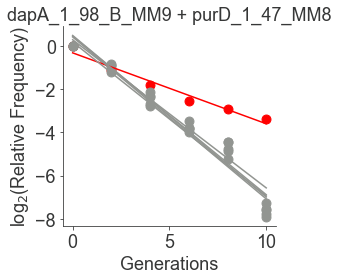

In [7]:
sgRNA1 = 'dapA_1_98_B_MM9'
sgRNA2 = 'purD_1_47_MM8'

fig, ax = plt.subplots(figsize=(4, 4))
colors = ['xkcd:gray', 'xkcd:gray', 'r', 'xkcd:gray', 'xkcd:gray', 'xkcd:gray']
for i, BC in enumerate(BC_list):
    ax.scatter(TPs, [df_normed[TP][BC].loc[sgRNA1, sgRNA2] for TP in TPs], s=80, color=colors[2*i])
    ax.plot(TPs, [x*growth_dict_BC[BC].loc[sgRNA1, sgRNA2] + b_dict_BC[BC].loc[sgRNA1, sgRNA2] for x in TPs],
            color=colors[2*i])  # Plot best fit line
    ax.scatter(TPs, [df_normed[TP][BC].loc[sgRNA2, sgRNA1] for TP in TPs], s=80, color=colors[2*i+1])
    ax.plot(TPs, [x*growth_dict_BC[BC].loc[sgRNA2, sgRNA1] + b_dict_BC[BC].loc[sgRNA2, sgRNA1] for x in TPs],
            color=colors[2*i+1])  # Plot best fit line
ax.set_title(f'{sgRNA1} + {sgRNA2}', fontsize=18)
ax.set_xlabel('Generations', fontsize=18)
ax.set_ylabel('log$_{2}$(Relative Frequency)', fontsize=18)
plt.tight_layout()
plt.show()

### Correlate growth rate data between barcodes and sgRNA orders

Internal replicates are barcoded, and sgRNA constructs should have comparable effects regardless of the barcode used. We see that this holds; the increase in dispersion at lower growth rates is expected as these data are fit from fewer sgRNA counts, and thus more susceptible to noise.

We then ensured that changing sgRNA order (whether a given sgRNA is in position 1 or position 2 in the construct) did not have a meaningful effect on growth rate. We see this holds as well. Note that the decrease in variation between sgRNA orders (when compared to deviation between barcodes) is expected, as the sgRNA order measurements are averaged across three barcoded replicates.

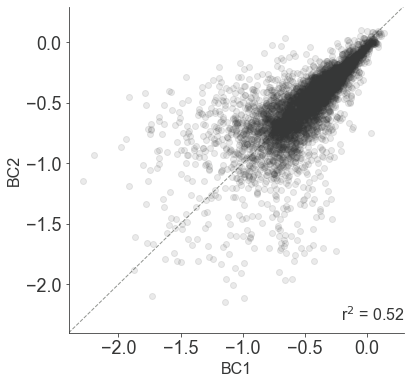

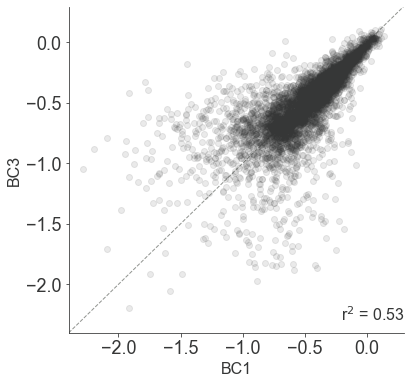

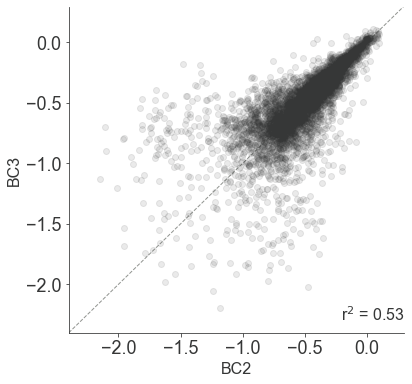

In [8]:
BC1, BC2, BC3 = [], [], []
for sgRNA1 in sgRNA_list:
    for sgRNA2 in sgRNA_list:
        BC1.append(growth_dict_BC[BC_list[0]].loc[sgRNA1, sgRNA2])
        BC2.append(growth_dict_BC[BC_list[1]].loc[sgRNA1, sgRNA2])
        BC3.append(growth_dict_BC[BC_list[2]].loc[sgRNA1, sgRNA2])
low_bound = np.nanmin(BC1 + BC2 + BC3) * 1.05
high_bound = np.nanmax(BC1 + BC2 + BC3) * 1.05
plot_correlation(BC1, BC2, 'BC1', 'BC2', low_bound, high_bound, 'FigS6Aa', figure_path)
plot_correlation(BC1, BC3, 'BC1', 'BC3', low_bound, high_bound, 'FigS6Ab', figure_path)
plot_correlation(BC2, BC3, 'BC2', 'BC3', low_bound, high_bound, 'FigS6Ac', figure_path)

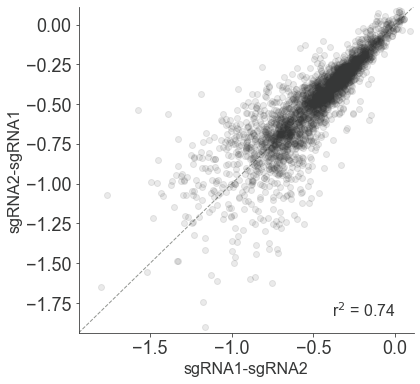

In [9]:
sg1_sg2, sg2_sg1 = [], []
for i, sgRNA1 in enumerate(sgRNA_list):
    for sgRNA2 in sgRNA_list[i+1:]:  # Only take non-redundant sgRNAs
        temp_order1 = np.array([growth_dict_BC[BC_list[0]].loc[sgRNA1, sgRNA2],
                                growth_dict_BC[BC_list[1]].loc[sgRNA1, sgRNA2],
                                growth_dict_BC[BC_list[2]].loc[sgRNA1, sgRNA2]])  # All barcodes, order 1
        temp_order2 = np.array([growth_dict_BC[BC_list[0]].loc[sgRNA2, sgRNA1],
                                growth_dict_BC[BC_list[1]].loc[sgRNA2, sgRNA1],
                                growth_dict_BC[BC_list[2]].loc[sgRNA2, sgRNA1]])  # All barcodes, order 2
        if sum(~np.isnan(temp_order1)) >= 2 and sum(~np.isnan(temp_order2)) >= 2:  # Check for sufficient data
            sg1_sg2.append(np.nanmean(temp_order1))
            sg2_sg1.append(np.nanmean(temp_order2))
low_bound = np.nanmin(sg1_sg2 + sg2_sg1) * 1.02
high_bound = np.nanmax(sg1_sg2 + sg2_sg1) * 1.2
plot_correlation(sg1_sg2, sg2_sg1, 'sgRNA1-sgRNA2', 'sgRNA2-sgRNA1', low_bound, high_bound, 'FigS6Ad', figure_path)

### Pool data by barcode and sgRNA order, remove escapers, and rescale growth rate data

We first pool growth rates by barcode and sgRNA order, then remove escapers using a one-sided Dixon Q-test at 95% confidence. After removing escapers, we average all constructs with at least four barcoded measurements remaining. Finally, we normalize each construct's mean growth rate by the minimum growth rate observed in the library, which rescales the nontargeting construct's growth rate to 1 and makes all growth rates non-negative.

In [10]:
dict_growth_pool = {}
for i, sgRNA1 in enumerate(sgRNA_list):
    dict_growth_pool[sgRNA1] = {}
    for sgRNA2 in sgRNA_list[i:]:
        dict_growth_pool[sgRNA1][sgRNA2] = np.array([])
for i, sgRNA1 in enumerate(sgRNA_list):
    for sgRNA2 in sgRNA_list[i:]:
        for BC in BC_list:
            dict_growth_pool[sgRNA1][sgRNA2] = np.append(dict_growth_pool[sgRNA1][sgRNA2],
                                                         growth_dict_BC[BC].loc[sgRNA1, sgRNA2])  # Pool by barcode
            if sgRNA1 != sgRNA2:  # If the construct has two distinct sgRNAs, pool by order
                dict_growth_pool[sgRNA1][sgRNA2] = np.append(dict_growth_pool[sgRNA1][sgRNA2],
                                                         growth_dict_BC[BC].loc[sgRNA2, sgRNA1])
        dict_growth_pool[sgRNA1][sgRNA2] = \
            dict_growth_pool[sgRNA1][sgRNA2][~np.isnan(dict_growth_pool[sgRNA1][sgRNA2])]  # Remove nans

In [11]:
df_growth_pool = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
df_growth_pool_sem = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
df_growth_pool_std = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
df_growth_pool_filt = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
df_growth_pool_filt_sem = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
df_growth_pool_filt_std = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
escaper_dict = {}
for i, sgRNA1 in enumerate(sgRNA_list):
    for sgRNA2 in sgRNA_list[i:]:
        gr_values = dict_growth_pool[sgRNA1][sgRNA2]
        if sgRNA1 != sgRNA2:  # Most constructs are of two distinct sgRNAs -- we require 4 replicates to fit
            reps_required = 4
        else:  # For these constructs, we only have 3 replicates -- require 2 to fit
            reps_required = 2
        if len(gr_values) >= reps_required:
            filt_gr_values, escaper_val = qtest_dixon(gr_values)  # Remove escapers
            if ~np.isnan(escaper_val):
                escaper_dict[f'{sgRNA1}-{sgRNA2}'] = escaper_val  # Record escapers
            df_growth_pool.loc[sgRNA2, sgRNA1] = np.mean(gr_values)
            df_growth_pool_sem.loc[sgRNA2, sgRNA1] = stats.sem(gr_values)
            df_growth_pool_std.loc[sgRNA2, sgRNA1] = np.std(gr_values)
            df_growth_pool_filt.loc[sgRNA2, sgRNA1] = np.mean(filt_gr_values)
            df_growth_pool_filt_sem.loc[sgRNA2, sgRNA1] = stats.sem(filt_gr_values)
            df_growth_pool_filt_std.loc[sgRNA2, sgRNA1] = np.std(filt_gr_values)
total_measurements = sum([sum(~np.isnan(growth_dict_BC[BC].values.flatten())) for BC in BC_list])
print(f'{len(escaper_dict)} escapers')
print(f'{total_measurements} total measurements')
print(f'{np.round(len(escaper_dict)/total_measurements*100, 3)}% dropped')

135 escapers
18440 total measurements
0.732% dropped


### Rescale growth rate data
Rescaling so the non-targeting control growth rate effect is 1 and the lowest observed growth rate effect is 0

In [12]:
gr_min = np.nanmin(df_growth_pool_filt.values)  # Minimum observed growth rate
df_growth_pool_filt_rescale = pd.DataFrame((df_growth_pool_filt.values - gr_min)/abs(gr_min), sgRNA_list, sgRNA_list)
df_growth_pool_filt_sem_rescale = pd.DataFrame(df_growth_pool_filt_sem.values/abs(gr_min), sgRNA_list, sgRNA_list)
df_growth_pool_filt_std_rescale = pd.DataFrame(df_growth_pool_filt_std.values/abs(gr_min), sgRNA_list, sgRNA_list)
simple_epistasis = pd.DataFrame(np.full([len(sgRNA_list), len(sgRNA_list)], np.nan), sgRNA_list, sgRNA_list)
for i, sgRNA1 in enumerate(sgRNA_list):
    for sgRNA2 in sgRNA_list[0:i]:  # Only use values above diagonal
        simple_epistasis.loc[sgRNA2, sgRNA1] = df_growth_pool_filt_rescale.loc[sgRNA1, sgRNA2] \
                                             - df_growth_pool_filt_rescale.loc[sgRNA1, 'negC_rand_42'] \
                                             * df_growth_pool_filt_rescale.loc[sgRNA2, 'negC_rand_42']

### Comparison to previous CRISPRi growth rate data

We compared growth rates for the CRISPRi perturbations targeting one or two of dapA, dapB, purL, and purN with the corresponding measurements from our initial pairwise assay. We expect the relative growth rates between these assays to correlate, although not exactly reproduce, as the library composition differed between experiments. These differences will not affect the absolute growth rate effect of any perturbation, but will impact the relative growth rate observed.

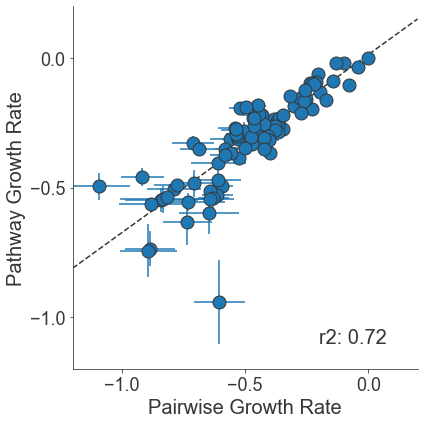

In [13]:
pairwise_gr, pairwise_sem, pathway_gr, pathway_sem = [], [], [], []
for sgRNA1 in df_growth_pool_filt.index:
    for sgRNA2 in df_growth_pool_filt.columns:
        if sgRNA1 in pairwise_gr_all.index and sgRNA2 in pairwise_gr_all.columns:
            if ~np.isnan(df_growth_pool_filt.loc[sgRNA1, sgRNA2]) and ~np.isnan(pairwise_gr_all.loc[sgRNA1, sgRNA2]):
                pairwise_gr.append(pairwise_gr_all.loc[sgRNA1, sgRNA2])
                pairwise_sem.append(pairwise_sem_all.loc[sgRNA1, sgRNA2])
                pathway_gr.append(df_growth_pool_filt.loc[sgRNA1, sgRNA2])
                pathway_sem.append(df_growth_pool_filt_sem.loc[sgRNA1, sgRNA2])

fig, ax = plt.subplots(figsize=(6, 6))
ax.errorbar(pairwise_gr, pathway_gr, xerr=pairwise_sem, yerr=pathway_sem, fmt='o', mec='xkcd:dark gray', ms=13)
m, b, r, _, _ = stats.linregress(pairwise_gr, pathway_gr)
ax.plot([-1.2, 0.2], [-1.2*m+b, 0.2*m+b], ls='--', color='xkcd:dark gray', zorder=0)
ax.set_xlabel('Pairwise Growth Rate', fontsize=20)
ax.set_ylabel('Pathway Growth Rate', fontsize=20)
ax.set_xticks([-1, -0.5, 0])
ax.set_yticks([-1, -0.5, 0])
ax.set_xlim([-1.2, 0.2])
ax.set_ylim([-1.2, 0.2])
ax.text(-0.2, -1.1, f'r2: {np.round(r**2, 3)}', fontsize=20)
plt.tight_layout()
plt.savefig(f'{figure_path}/FigS6B.pdf')
plt.show()

### Plot escaper effects on growth rate mean and growth rate sem

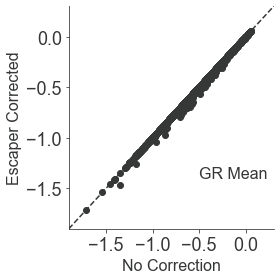

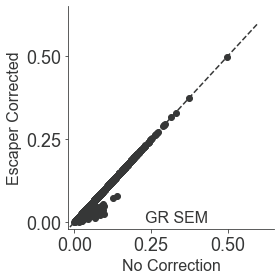

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(df_growth_pool, df_growth_pool_filt, marker='o', color='xkcd:dark gray')
ax.plot([-1.9, 0.4], [-1.9, 0.4], ls='--', color='xkcd:dark gray', zorder=0)
ax.text(-0.5, -1.4, 'GR Mean', fontsize=16)
ax.set_xlim(-1.9, 0.3)
ax.set_ylim(-1.9, 0.3)
ax.set_xticks([-1.5, -1, -0.5, 0])
ax.set_yticks([-1.5, -1, -0.5, 0])
ax.set_xlabel('No Correction', fontsize=16)
ax.set_ylabel('Escaper Corrected', fontsize=16)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(df_growth_pool_sem, df_growth_pool_filt_sem, marker='o', color='xkcd:dark gray')
ax.plot([-0.05, 0.6], [-0.05, 0.6], ls='--', color='xkcd:dark gray', zorder=0)
ax.set_xlim(-0.02, 0.65)
ax.set_ylim(-0.02, 0.65)
ax.set_xticks([0, 0.25, 0.5])
ax.set_yticks([0, 0.25, 0.5])
ax.set_xlabel('No Correction', fontsize=16)
ax.set_ylabel('Escaper Corrected', fontsize=16)
ax.text(0.23, 0, 'GR SEM', fontsize=16)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

### Plot growth rate and growth rate epistasis for the pairwise CRISPRi library

We calculated growth rate epistasis using a multiplicative model using the following formula.

$epi_{a,b}$ = $gr_{a,b}$ - $gr_a$ * $gr_b$

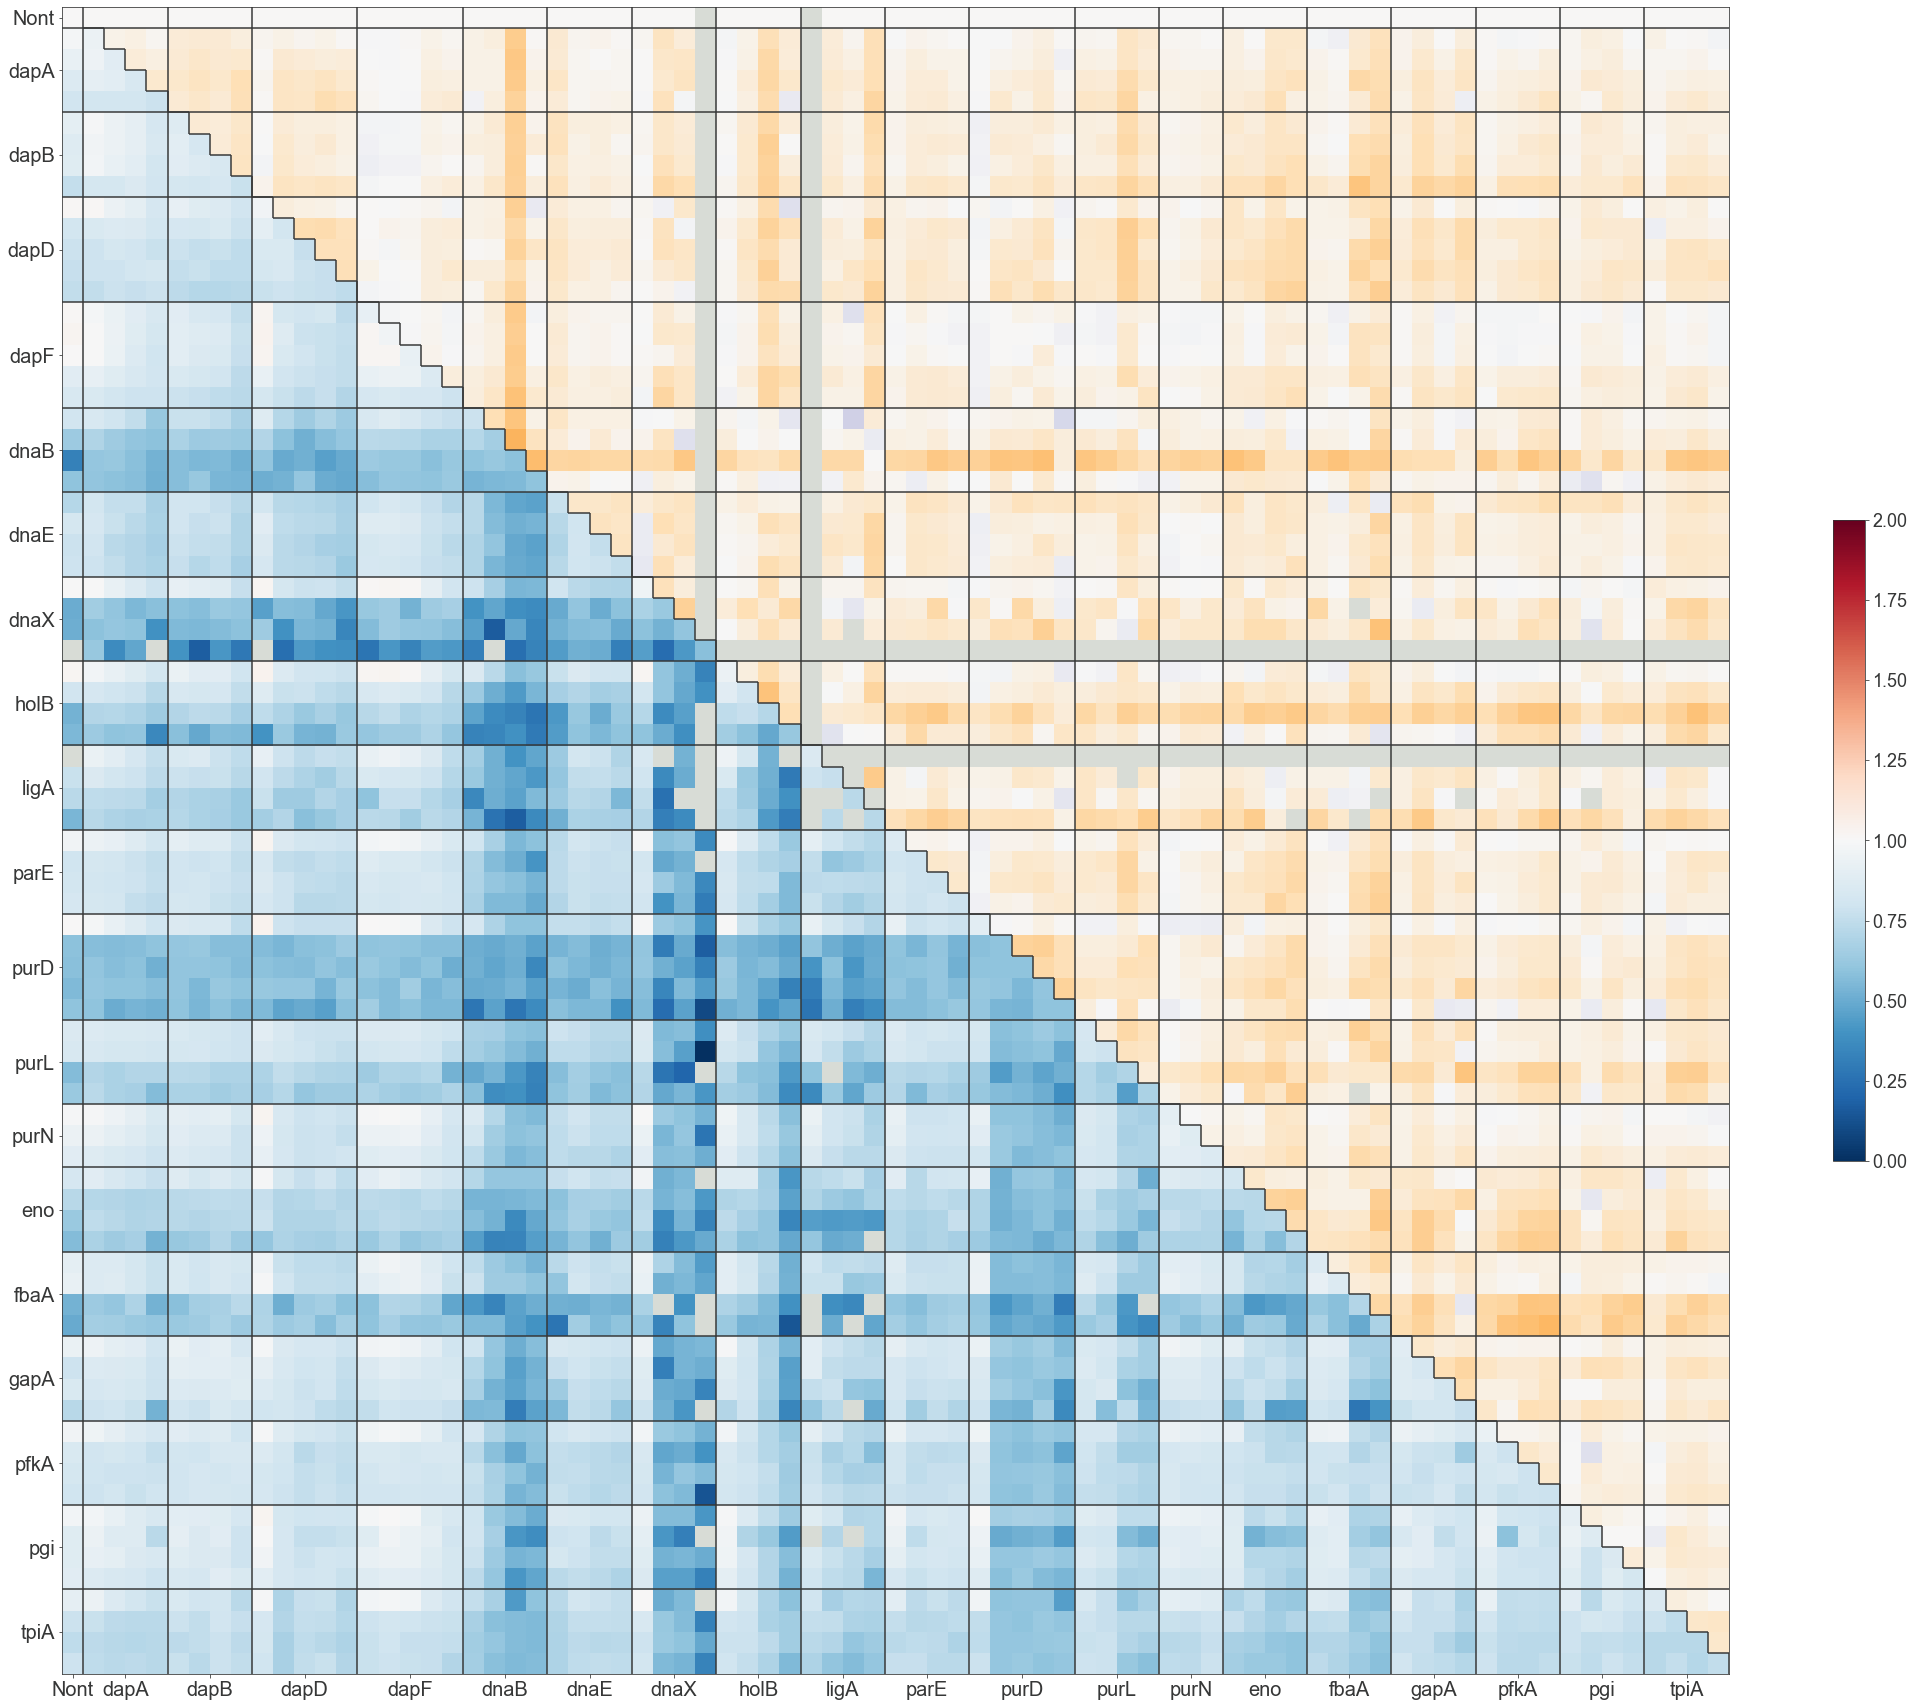

In [15]:
fig, ax = plt.subplots(figsize=(30, 30))
im = ax.imshow(df_growth_pool_filt_rescale, vmin=0, vmax=2, cmap='RdBu_r')
fig.colorbar(im, shrink=0.3)
ax.tick_params(axis='both', labelsize=20)
ax.set_facecolor('xkcd:light gray')
ax.grid(which='minor', color='xkcd:dark gray', linestyle='-', linewidth=0.25)
grid_lines = [-0.5, 0.5]  # Set up grids to divide sgRNA groups by the gene they target
labels = ['Nont', sgRNA_list[1].split('_')[0]]  # Target gene names
ax.hlines(0.5, -0.5, len(sgRNA_list)-0.5, color='xkcd:dark gray')  # Nont sgRNA
ax.vlines(0.5, -0.5, len(sgRNA_list)-0.5, color='xkcd:dark gray')  # Nont sgRNA
for i, sgRNA in enumerate(sgRNA_list[1:]):
    if sgRNA.split('_')[0][0:4] != labels[-1]:  # Switching to a new sgRNA group
        grid_lines.append(i+0.5)
        labels.append(sgRNA.split('_')[0])
        ax.hlines(i+0.5, -0.5, len(sgRNA_list)-0.5, color='xkcd:dark gray')
        ax.vlines(i+0.5, -0.5, len(sgRNA_list)-0.5, color='xkcd:dark gray')
    ax.hlines(i+0.5, i+0.5, i+1.5, color='xkcd:dark gray')  # Lines just across diagonal
    ax.vlines(i+1.5, i+0.5, i+1.5, color='xkcd:dark gray')  # Lines just across diagonal
grid_lines.append(i+1.5)
centers = []  # Center of each sgRNA group
for i, grid in enumerate(grid_lines[:-1]):
    centers.append((grid+grid_lines[i+1]) / 2)
im = ax.imshow(simple_epistasis, vmin=-1, vmax=1, cmap='PuOr_r')
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.spines[['top', 'right']].set_visible(True)
plt.tight_layout()
plt.show()

### Interreplicate RMSD

We calculate RMSD between experimental replicates by taking the error between each individual measurement and the mean growth rate across all replicates of that construct. This RMSD is assumed to be the theoretical minimum error for predicted growth rates.

In [16]:
sq_errs = []
for BC in BC_list:
    for i, sgRNA1 in enumerate(sgRNA_list):
        for sgRNA2 in sgRNA_list[i+1:]:  # Non-redundant constructs
            if sgRNA1.split('_')[0] != sgRNA2.split('_')[0]:  # We don't investigate same gene sgRNAs
                sq_errs.extend([((growth_dict_BC[BC].loc[sgRNA1, sgRNA2]-gr_min)/abs(gr_min)
                                - df_growth_pool_filt_rescale.loc[sgRNA2, sgRNA1])**2, 
                               ((growth_dict_BC[BC].loc[sgRNA2, sgRNA1]-gr_min)/abs(gr_min)
                                - df_growth_pool_filt_rescale.loc[sgRNA2, sgRNA1])**2])
data_RMSD = np.sqrt(np.nanmean(sq_errs))
print(f'Data RMSD: {data_RMSD}')

Data RMSD: 0.08335478206548441


### Generate tables and export data

In [17]:
#  Table E2. Pathway sgRNA growth rates.
table_e2 = pd.DataFrame(np.full((int(((len(sgRNA_list)-1)*(len(sgRNA_list)-1))/2), 4), np.nan),
                        columns=['sgRNA1', 'sgRNA2', 'Growth Rate', 'Growth Rate SEM'])
count = 0
for i, sgRNA1 in enumerate(sgRNA_list):
    for sgRNA2 in sgRNA_list[i:]:
        table_e2.loc[count] = [sgRNA1, sgRNA2, np.round(df_growth_pool_filt_rescale.loc[sgRNA2, sgRNA1], 3),
                               np.round(df_growth_pool_filt_sem_rescale.loc[sgRNA2, sgRNA1], 3)]
        count += 1

In [18]:
with open(f'{file_path}/{date}_path_df_growth_pool_filt.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_df_growth_pool_filt_sem.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt_sem, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_df_growth_pool_filt_std.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_df_growth_pool_filt_rescale.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt_rescale, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_df_growth_pool_filt_sem_rescale.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt_sem_rescale, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_df_growth_pool_filt_std_rescale.pickle', 'wb') as handle:
    pickle.dump(df_growth_pool_filt_std_rescale, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_dict_growth_pool.pickle', 'wb') as handle:
    pickle.dump(dict_growth_pool, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{file_path}/{date}_path_gr_min.pickle', 'wb') as handle:
    pickle.dump(gr_min, handle, protocol=pickle.HIGHEST_PROTOCOL)
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:  
    table_e2.to_excel(writer, sheet_name='Table Extra2')